In [23]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [24]:
guesthouse = pd.read_excel('Guesthouse..xls')
guesthouse.head(5)

,Name,Number of guests,Nacionality,Gender,Price,Price per night,Number of nights,Check-in,Check out,Year,Month,Months,Review,Rooms
0,Artur,1,Brazil,M,73.0,24.333333,3,2017-04-12,2017-04-15 00:00:00,2017,4,Apr,1,Blue Room
1,Jon,1,South korea,M,73.0,24.333333,3,2017-02-11,2017-02-14 00:00:00,2017,2,Feb,1,Blue Room
2,Kleber,1,Brazil,M,270.0,27.000000,10,2017-02-20,2017-03-02 00:00:00,2017,2,Feb,1,Blue Room
3,Judith,2,Germany,F,73.0,36.500000,2,2017-07-03,2017-07-05 00:00:00,2017,7,Jul,1,Double Room
4,Elisa Yuan,2,UK,F,44.0,44.000000,1,2017-04-08,2017-04-09 00:00:00,2017,4,Apr,0,Double Room


In [25]:
guesthouse.describe()

,Number of guests,Price,Price per night,Number of nights,Year,Month,Review
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,2.203636,139.056655,51.180956,2.876364,2017.440000,6.505455,0.338182
std,1.296537,162.132529,29.498074,2.509687,0.497292,3.112690,0.473953
min,1.000000,24.080000,12.500000,1.000000,2017.000000,1.000000,0.000000
25%,1.000000,60.195000,30.340000,1.000000,2017.000000,4.000000,0.000000
50%,2.000000,89.570000,40.770000,2.000000,2017.000000,7.000000,0.000000
75%,3.000000,151.105000,64.318333,3.000000,2018.000000,9.000000,1.000000
max,5.000000,1597.000000,153.024000,24.000000,2018.000000,12.000000,1.000000


In [26]:
guesthouse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Name              275 non-null    object        
 1   Number of guests  275 non-null    int64         
 2   Nacionality       275 non-null    object        
 3   Gender            275 non-null    object        
 4   Price             275 non-null    float64       
 5   Price per night   275 non-null    float64       
 6   Number of nights  275 non-null    int64         
 7   Check-in          275 non-null    datetime64[ns]
 8   Check out         275 non-null    object        
 9   Year              275 non-null    int64         
 10  Month             275 non-null    int64         
 11  Months            275 non-null    object        
 12  Review            275 non-null    int64         
 13  Rooms             275 non-null    object        
dtypes: datetime64[ns](1), floa

In [27]:
guesthouse.corr()

,Number of guests,Price,Price per night,Number of nights,Year,Month,Review
Number of guests,1.000000,0.490452,0.893762,-0.016910,0.019019,-0.011128,0.000367
Price,0.490452,1.000000,0.460526,0.715281,0.049580,-0.005065,0.073998
Price per night,0.893762,0.460526,1.000000,-0.110605,-0.028138,0.038354,0.024732
Number of nights,-0.016910,0.715281,-0.110605,1.000000,-0.003041,-0.023740,0.130396
Year,0.019019,0.049580,-0.028138,-0.003041,1.000000,-0.585105,-0.587179
Month,-0.011128,-0.005065,0.038354,-0.023740,-0.585105,1.000000,0.227579
Review,0.000367,0.073998,0.024732,0.130396,-0.587179,0.227579,1.000000


In [28]:
# Let's check how many unique nacionalities?
guesthouse['Nacionality'].nunique()

41

Heat Map

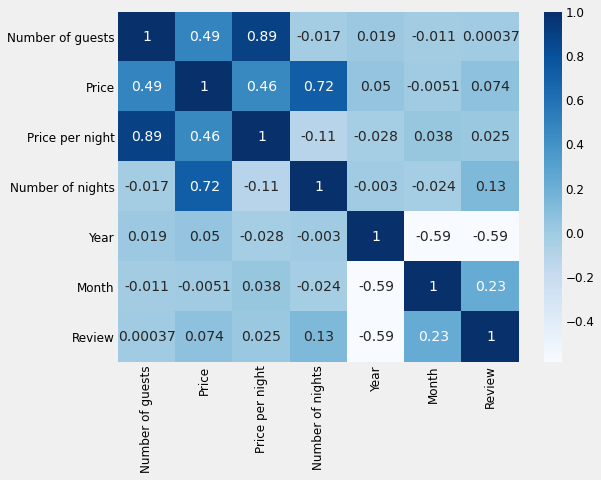

In [29]:
plt.figure(figsize=(8,6))
sns.heatmap(guesthouse.corr(),annot=True,cmap="Blues")
plt.show()

Scatter Plot

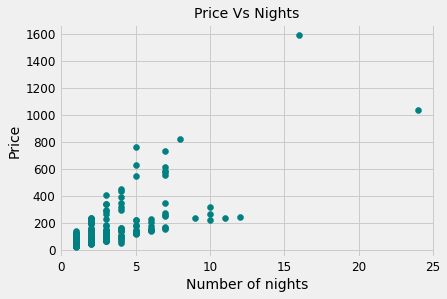

In [30]:
plt.scatter(guesthouse['Number of nights'], guesthouse['Price'], color='teal')
plt.title('Price Vs Nights', fontsize=14)
plt.xlabel('Number of nights', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid(True)
plt.show()

Chart Bart

Text(0.5, 1.0, 'TOP 15 GUEST NACIONALITIES.')

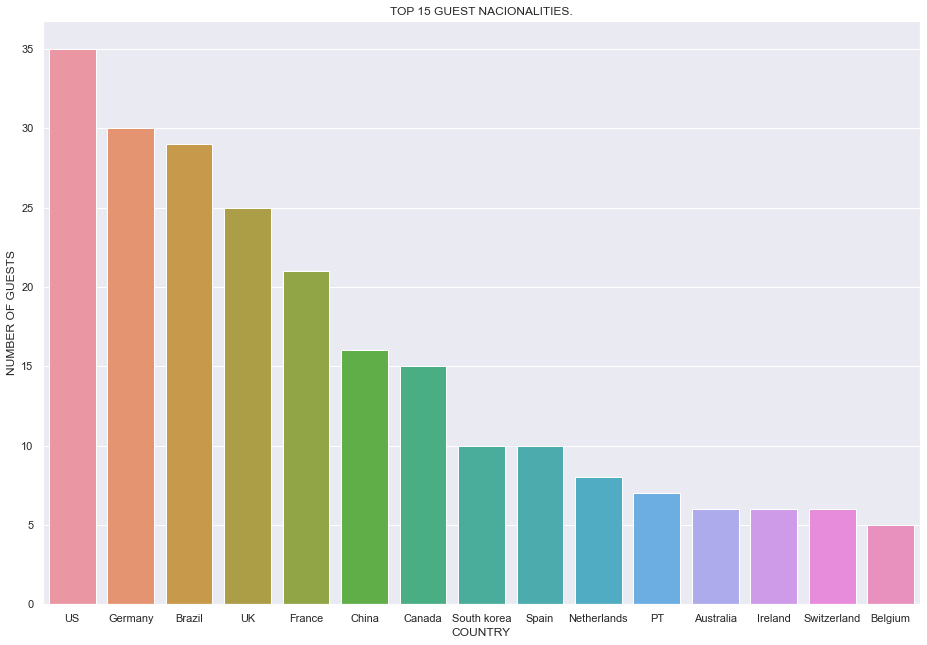

In [32]:
fig_1 = pd.DataFrame(guesthouse.Nacionality.value_counts(dropna=False).head(15))
fig_1
sns.set(rc={'figure.figsize':(14,10)})
ax = sns.barplot(fig_1.index,fig_1['Nacionality'])
plt.ylabel('NUMBER OF GUESTS')
plt.xlabel('COUNTRY')
plt.title("TOP 15 GUEST NACIONALITIES.")

Pie Chart

Text(0.5, 1.0, 'Percentage of Male Vs Female guests.')

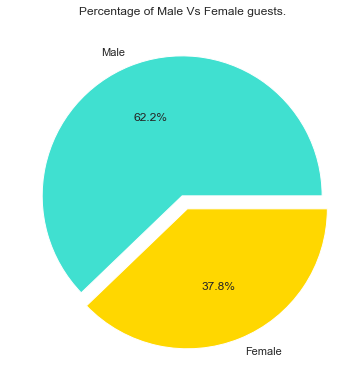

In [33]:
plt.figure(figsize=(8,6))
plt.pie(x=guesthouse['Gender'].value_counts(),autopct='%1.1f%%',explode=(0,0.1), colors = ['turquoise', 'gold'], labels=['Male','Female'])
plt.title('Percentage of Male Vs Female guests.')

In [34]:
# Get guests count for each room
guests_count = guesthouse.groupby('Rooms').count()

# Reset index
guests_count = guests_count.reset_index()


# Create new dataframe for city name and hostel count
guests_count = guests_count[["Rooms", "Number of guests"]]

# Rename columns
guests_count.rename(columns={"Number of guests": "Guests count"}, inplace=True)

Text(0, 0.5, 'Number of guests')

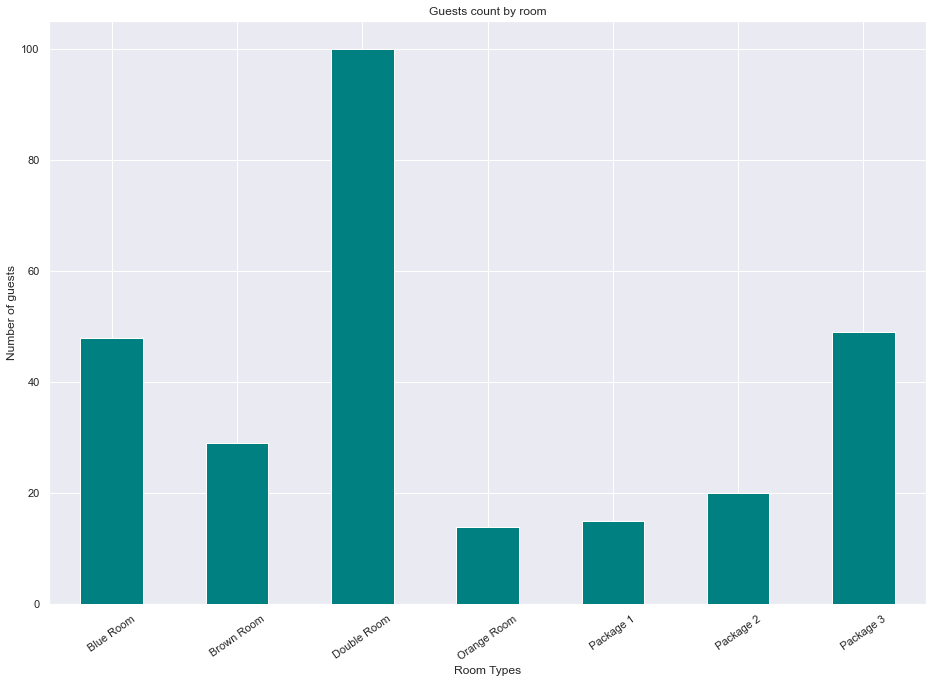

In [36]:
# Create bar chart for number of guests count by room
room_plot = guests_count.plot.bar(x="Rooms", y="Guests count", rot=90, legend=None, color="teal", zorder=3)
plt.grid(which="major", axis="y", zorder=0)
plt.xticks(rotation=35)
plt.title("Guests count by room")
plt.xlabel("Room Types")
plt.ylabel("Number of guests")

In [37]:
# Obtain the mean and standard deviation (STD)
price_mean = guesthouse.groupby(["Rooms"]).mean()["Price per night"]
display(price_mean)

price_std = guesthouse.groupby(["Rooms"]).std()["Price per night"]
display(price_std)

Rooms
Blue Room       28.831838
Brown Room      27.696469
Double Room     41.593619
Orange Room     30.297381
Package 1       61.202000
Package 2       58.607702
Package 3      106.406687
Name: Price per night, dtype: float64

Rooms
Blue Room       7.866793
Brown Room      4.842596
Double Room     8.455497
Orange Room     4.641701
Package 1      16.456673
Package 2      16.796440
Package 3      15.153235
Name: Price per night, dtype: float64

Text(0, 0.5, 'Price')

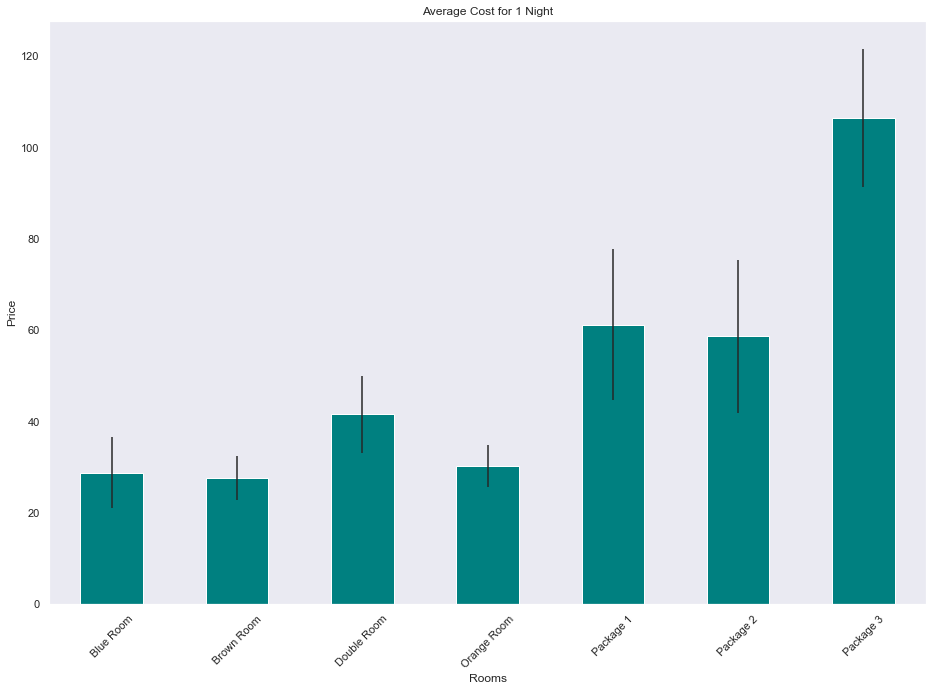

In [38]:
# Create new dataframe for mean values
mean_df = pd.DataFrame({"Rooms":price_mean.index, "Price per night":price_mean.values})
mean_df = mean_df.set_index("Rooms")
mean_df

# Create bar chart with y error bar 
mean_df.plot(kind="bar", yerr=price_std.values, color="teal", legend=None)
plt.xticks(rotation=45)
plt.grid()
plt.title("Average Cost for 1 Night")
plt.ylabel("Price")

Levene's Test (for testing variance)

Price Vs Room Types

In [40]:
import scipy.stats as st

In [41]:
clean_guesthouse = guesthouse.drop([5, 9, 49, 113, 145, 158, 184, 226, 232, 235, 240])

In [42]:
clean_guesthouse['Price'].max()

448.77

In [43]:
clean_guesthouse.Rooms.unique()

array(['Blue Room', 'Double Room', 'Package 1', 'Package 3', 'Package 2',
       'Brown Room', 'Orange Room'], dtype=object)

In [44]:
pvt = clean_guesthouse[clean_guesthouse['Rooms'] == 'Blue Room']
pvt = clean_guesthouse[clean_guesthouse['Rooms'] == 'Brown Room']
pvt = clean_guesthouse[clean_guesthouse['Rooms'] == 'Orange Room']
dbl = clean_guesthouse[clean_guesthouse['Rooms'] == 'Double Room']
apt = clean_guesthouse[clean_guesthouse['Rooms'] == 'Package 1']
apt = clean_guesthouse[clean_guesthouse['Rooms'] == 'Package 2']
apt = clean_guesthouse[clean_guesthouse['Rooms'] == 'Package 3']

In [45]:
st.levene(pvt.Price, dbl.Price, apt.Price)

LeveneResult(statistic=15.214352053200349, pvalue=9.636563483406991e-07)

In [47]:
print(f'Since p value is less than alpha (5% - assumed), the null hypothesis is rejected. Therefore, the distribution is not normal (as could be seen from the Distribution Plot.')

Since p value is less than alpha (5% - assumed), the null hypothesis is rejected. Therefore, the distribution is not normal (as could be seen from the Distribution Plot.


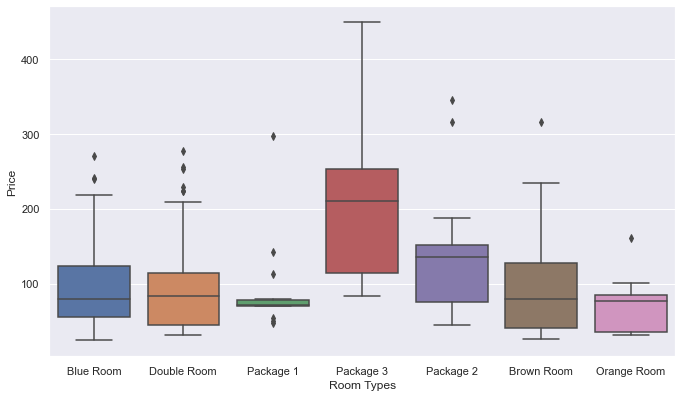

In [48]:
plt.figure(figsize=(10,6))
sns.boxplot(y='Price',x='Rooms',data=clean_guesthouse)
plt.xlabel('Room Types')
plt.show()